In [3]:
import pandas as pd
import h5py
from Bio import SeqIO
from copy import deepcopy 
import numpy as np
import seaborn as sns
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
from sklearn.decomposition import PCA
import pickle
import re

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,RocCurveDisplay
from matplotlib.colors import to_hex

import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'

def load_embedding(file_name):
    f = h5py.File(file_name)
    Xg = []
    gene_names = list(f.keys())
    for key in f.keys():
        Xg.append(f[key][()])
    f.close()
    Xg = pd.DataFrame(np.asmatrix(Xg),index=gene_names)
    return Xg,gene_names

kos = pd.read_csv("../data/gtdb/keggGeneNames.csv",index_col=0)

def compute_summary_stats(df,group_by_id = "ko"):
    KOs = []
    Mo = []
    W = []
    for KO, dff in df.groupby(group_by_id):
        Mo.append((dff.predict == 'Mo').sum())
        W.append((dff.predict == 'W').sum())
        KOs.append(KO)
    results_predictions = pd.DataFrame({"KO":KOs,"Mo":Mo,"W":W})

    rp = results_predictions.set_index("KO").join(kos.set_index('KO'))

    rp['Mo (%)']= 100*rp['Mo']/(rp['Mo'] + rp['W'])
    rp['W (%)']= 100*rp['W']/(rp['Mo'] + rp['W'])
    return rp




In [6]:
#model = pd.read_pickle("lrmodel.l2reg.embedding2mow.10Jan2023.pkl")
model = pd.read_pickle("../data/ml-models/lrmodel.l1reg.embedding2mow.18Feb2023.pkl")


In [8]:
# load wells embedding
# REACH OUT TO goldford@caltech.edu for this file since it's >100 MB
file_name = '../data/Wells2020/FDHChalcOR_wSerAspligands.embedding.29Nov2022.h5'
DMSOR_sm,gns = load_embedding(file_name)
predictions = model.predict(DMSOR_sm)
predictions = pd.DataFrame({'predictions':predictions},index=DMSOR_sm.index)

In [9]:
geneNames = []
taxaNames = []

for gene,row in predictions.iterrows():
    gene = gene[0].upper() + gene[1:]
    i = [ match.start() for match in re.finditer ("[A-Z]", gene) ][1]

    taxa = gene[0:i]
    genename = gene[i:]
    geneNames.append(genename)
    taxaNames.append(taxa)
    
#e = predictions.index.tolist()[0]
predictions["geneName"] = geneNames
predictions["taxa"] = taxaNames

In [11]:
len(predictions["geneName"].unique())

37

In [45]:
## make color df for tree
#mo_color = to_hex(sns.palettes.color_palette("Set2")[0])
#w_color = to_hex(sns.palettes.color_palette("Set2")[1])
#cmap = {}
#cmap["Mo"] =mo_color
#cmap["W"] =w_color
#predictions.to_csv("CofactorPredictions.DMSOR.l1reg18Feb2023.csv")
#r = pd.DataFrame(predictions["predictions"].apply(lambda x: cmap[x]))

In [15]:
# REACH OUT TO goldford@caltech.edu for this file since it's ~1GB

f = "../data/gtdb/gtdb.pterinSeqs.embed.22Dec2022.h5"
pterinEmbeddingGTDB,gns = load_embedding(f)
predictions_pterinEmbeddingGTDB= model.predict(pterinEmbeddingGTDB)
predictions_pterinEmbeddingGTDB_probs = model.predict_proba(pterinEmbeddingGTDB)
predictions_pterinEmbeddingGTDB = pd.DataFrame({'predict':predictions_pterinEmbeddingGTDB},index=pterinEmbeddingGTDB.index)
del pterinEmbeddingGTDB

predictions_pterinEmbeddingGTDB['gene_id']= [x.split(' ')[0] for x in gns]
predictions_pterinEmbeddingGTDB.set_index("gene_id",inplace=True)

#gnt = pd.read_csv("../data/sequenceTable.pterinDomains.gtdb.22Dec2022.csv",index_col=0)
gnt = pd.read_csv("../data/gtdb/pterin-binding-gene-table.csv",index_col=0)

gnt['gene name'] = gnt['gene name'].apply(lambda x: x.replace('.',"_"))
predictions_pterinEmbeddingGTDB = predictions_pterinEmbeddingGTDB.join(gnt.set_index("gene name"))

In [17]:
# make count number of genes that are Mo and W specific
mo_w_aors = predictions_pterinEmbeddingGTDB[predictions_pterinEmbeddingGTDB.KO.isin(["K03738"])].groupby("predict").count()[["KO"]]
mo_w_aors.columns = ["gene count"]
mo_w_aors


,gene count
predict,
Mo,388
W,22920


In [18]:
z = predictions_pterinEmbeddingGTDB[predictions_pterinEmbeddingGTDB.KO.isin(["K03738"])]

In [19]:
len(z[z.predict == "Mo"]) / len(z)

0.01664664492877982

In [26]:
stats_tab_gtdb = compute_summary_stats(predictions_pterinEmbeddingGTDB,group_by_id="KO")
stats_tab_gtdb

,Mo,W,name,gene_name,Mo (%),W (%)
KO,,,,,,
K00087,2059,0,"ygeS, xdhA; xanthine dehydrogenase molybdenum-...","ygeS, xdhA",100.000000,0.000000
K00203,1039,63,"fwdD, fmdD; formylmethanofuran dehydrogenase s...","fwdD, fmdD",94.283122,5.716878
K00367,1692,0,narB; ferredoxin-nitrate reductase [EC:1.7.7.2],narB,100.000000,0.000000
K00370,9314,10,"narG, narZ, nxrA; nitrate reductase / nitrite ...","narG, narZ, nxrA",99.892750,0.107250
K00387,410,0,SUOX; sulfite oxidase [EC:1.8.3.1],SUOX,100.000000,0.000000
K02567,4620,0,napA; nitrate reductase (cytochrome) [EC:1.9.6.1],napA,100.000000,0.000000
K03520,20005,0,"coxL, cutL; aerobic carbon-monoxide dehydrogen...","coxL, cutL",100.000000,0.000000
K03738,388,22920,aor; aldehyde:ferredoxin oxidoreductase [EC:1....,aor,1.664664,98.335336
K04108,52,0,"hcrA, hbaC; 4-hydroxybenzoyl-CoA reductase sub...","hcrA, hbaC",100.000000,0.000000


Text(0, 0.5, 'proportion of sequences')

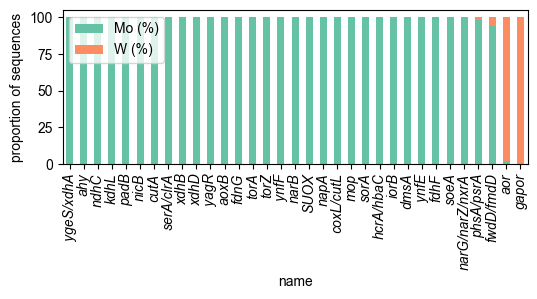

In [28]:
c =  sns.color_palette('Set2')[0:2]
#rbd = rp.set_index('gene_name')[['Mo (%)',"W (%)"]]
rbd = stats_tab_gtdb.set_index('gene_name')[['Mo (%)',"W (%)"]]
rbd['name'] = [x.replace(', ','/') for x in rbd.index.tolist()]
rbd.set_index("name",inplace=True)
rbd.sort_values("W (%)")[['Mo (%)',"W (%)"]].plot(kind='bar', stacked=True,figsize=(6,2),color=c)
plt.xticks(style="italic")
plt.ylabel("proportion of sequences")
